In [1]:
import numpy as np
import h5py
import json
import os
import pandas as pd
from model import *
from IPython import display
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import ScalarMappable
matplotlib.rcParams['animation.embed_limit'] = 40
matplotlib.rcParams['animation.ffmpeg_path'] = '/Users/patrick/Downloads/ffmpeg'

In [4]:
# Read in shared ('project level') data
with open(os.path.join(os.getcwd(), 'project_info.json'), 'r') as info_file:
    proj_info = json.load(info_file)

# Get list of run numbers
rundirs = os.listdir('runs')
try:
    runnums = np.arange(len(rundirs.remove('.DS_Store')))
except:
    runnums = np.arange(len(rundirs))

scatter plots

    x-axis
        K
        - proportional rate of change (like climate change exposure rate) for the longest period between merging/splitting events
        fire prob
        - average over space and time for the longest period between merging/splitting events
        - (proportional?) rate of change for the longest period between merging/splitting events
    y axis
        - proportional abundance rate of change for the longest period between merging/splitting events
        
how much does the change in fire prob matter?
    
    histogram changes in prob over patches, compare to popsuc vs fireprob single patch test

In [19]:
run = open_run(74)
with h5py.File(os.path.join(run.run_dir, 'results.h5'), 'r') as res:
    ab = np.array(res['mean']['pop22'])

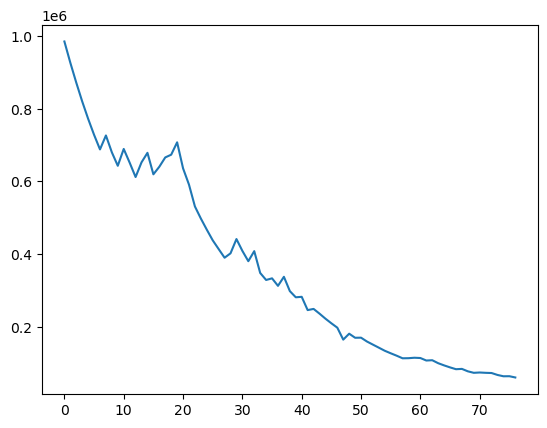

In [20]:
plt.plot(ab)

Check for "S" in populations in mp file, if number after "S" is an initially occupied patch, mark a split timestep (based on time after "T") there for that initial patch #. 

No, just assume the pop numbers in the split markers in mp file are correct, mark a split timestep for each at that point.

In [5]:
for runnum in runnums:
    run = open_run(runnum)
    # Select specific climate model/scenario
    if (run.spatial == False) or (run.climate_model != 'cnrm') or (run.climate_scenario != 'rcp45'):
        continue
    with h5py.File(os.path.join(run.run_dir, 'results.h5'), 'r') as res:
        print(res.keys())
        pops = np.arange(run.get_num_pops())
        for pop in pops[1:]:
            poplab = 'pop'+str(pop)
            # Filter out populations with zero abundance for whole simulation
            if np.all(np.array(res['mean'][poplab]) == 0):
                continue
            # Find timestep where this population appears
            init_i = np.nonzero(res['mean'][poplab])[0][0]
            print(pop, init_i)
            
            # Check for any splits in this population
            with open(os.path.join(run.run_dir, 'final.mp'), 'r') as mp:
                for ln_idx, ln in mp:
                    print(ln)
                    break
            break
            
            if run.fixed_habitat == False:
                # habitat_metric = 
                # print(np.array(res['K'][poplab]))
                pass
    break

<KeysViewHDF5 ['K', 'fire_prob', 'max', 'mean', 'min', 'patch_centroids', 'stdev']>
1 0


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 36: invalid start byte

It would make sense if the first time step (t=1) was run with the initial abundances. However, RAMAS seems to run an initial timestep 0 with the initial abundances, as the abundances change (decrease) going from t=0 to t=1. What probability and carrying capacity is used for t=0? Know that (KCH[0], PCH[0]) -> t=1 to t=31,  (KCH[1], PCH[1]) -> t=31 to t=32, (KCH[2], PCH[2]) -> t=32 to t=33, ..., (KCH[45], PCH[45]) -> t=75 to t=76. So for now, I'm going to ignore the first and the last timesteps.

In [1]:
# Load results into memory as a dictionary
def get_resdata(inst):
    resdata = {}
    resultsfn = os.path.join(inst.run_dir, 'results.h5')
    with h5py.File(resultsfn, 'r') as results:
        for qty in results.keys():
            resdata.update({qty: {}})
            for patch in results[qty].keys():
                if qty in ['mean', 'max', 'min', 'stdev']:
                    # Trim the first and last time step off abundance stats
                    resdata[qty].update({patch: np.array(results[qty][patch])[1:-1]})
                else:
                    resdata[qty].update({patch: np.array(results[qty][patch])})
    return resdata

# Function to return quantity for plotting given keyword
def plot_qty(resdata, patch, t, qty):
    if qty == 'diff_from_init':
        init_i = np.nonzero(resdata['mean'][patch])[0][0]
        val = resdata['mean'][patch][t] - resdata['mean'][patch][init_i]
    if qty == 'scaled_avg_abund':
        val = resdata['mean'][patch][t] / resdata['K'][patch][t]
    if qty == 'rel_to_init':
        init_i = np.nonzero(resdata['mean'][patch])[0][0]
        val = resdata['mean'][patch][t] / resdata['mean'][patch][init_i]
    return val

def update(t):
    # Grab data for time t
    ys, xs, zs, fire_probs = [], [], [], []
    for patch in patches:
        # Check a few things before plotting point
        patch_checks = []
        patch_checks.append(resdata['mean'][patch][t] != 0)
        patch_checks.append(np.all(resdata['mean'][patch] == 0) == False)
        patch_checks.append(((0.0 == 0.0) and (1.0 == 0.0)) == False)
        if (resdata['mean'][patch][t] != 0) and (np.all(resdata['mean'][patch] == 0) == False):
            # Take diff from ylim to convert from row index to y coordinate
            '''Should change indexing in results to (x,y) instead of (y,x)'''
            y = ylim - resdata['patch_centroids'][patch][t][0]
            x = resdata['patch_centroids'][patch][t][1]
            # Check that patch centroid is not a placeholder before storing
            if ((x == 0.0) and (y == ylim)) == False:
                ys.append(y)
                xs.append(x)
            else:
                continue
            # Get value of population success metric
            z = plot_qty(resdata, patch, t, qty)
            zs.append(z)
            # Get pop fire probability at time t 
            prob = resdata['fire_prob'][patch][t]
            fire_probs.append(prob)
    # Plot at a few viewing angles
    fig.clear()
    ms = '^' if t <= 29 else 'o' #change marker for burn in period
    for i, view in enumerate(views):
        ax = fig.add_subplot(2,2,i+1,projection='3d')
        ax.view_init(elev=view[0], azim=view[1])
        ax.ticklabel_format(useOffset=False)
        ax.set_zlim(zmin,zmax)
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
        ax.set_xlabel('x coordinate', fontsize=axfont)
        ax.set_ylabel('y coordinate', fontsize=axfont)
        ax.set_zlabel(qty, fontsize=axfont)
        ax.scatter(xs, ys, zs, c=fire_probs, cmap=cmap, norm=norm, 
                   depthshade=False, marker=ms, s=45)
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.75)
    plt.suptitle('{}_{}'.format(inst.climate_model,inst.climate_scenario), fontsize=20)

NameError: name 'os' is not defined

## animation

In [ ]:
for run in runs:
    # Grab a specific run
    with open(os.path.join(os.getcwd(), 'runs', str(run), 'run_info.json')) as info_file:
        run_info = json.load(info_file)
    inst = Model(**run_info)
    
    # Check that this is a spatial run
    if inst.spatial == False:
        continue

    # Load results into memory as a dictionary
    resdata = {}
    resultsfn = os.path.join(inst.run_dir, 'results.h5')
    with h5py.File(resultsfn, 'r') as results:
        for qty in results.keys():
            resdata.update({qty: {}})
            for patch in results[qty].keys():
                if qty in ['mean', 'max', 'min', 'stdev']:
                    # Trim the first and last time step off abundance stats
                    resdata[qty].update({patch: np.array(results[qty][patch])[1:-1]})
                else:
                    resdata[qty].update({patch: np.array(results[qty][patch])})
    patches = list(resdata['patch_centroids'].keys())
    patches.remove('pop0')
    vmax = max([np.max(resdata['fire_prob'][patch]) for patch in patches])
    vmin = min([np.min(resdata['fire_prob'][patch]) for patch in patches if np.min(resdata['fire_prob'][patch]) != 0.0])
    # cmap = matplotlib.colormaps.get_cmap('viridis')#('YlOrRd')
    cmap = matplotlib.pyplot.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    xlim = run_info['lr_coord'][0] - run_info['ul_coord'][0]
    ylim = run_info['lr_coord'][1] - run_info['ul_coord'][1]
    axfont = 12
    tsteps = int((proj_info['tf'] - proj_info['ti'])/inst.timestep) + inst.burn_in_period
    ts = np.arange(tsteps)
    qty = 'rel_to_init'
    views = [(10,210),(10,275),(10,340),(85,270)]#,(10,40)]

    all_zs = []
    for t in ts:
        for patch in patches:
            if (resdata['mean'][patch][t] != 0) and (np.all(resdata['mean'][patch] == 0) == False):
                # Get value of population success metric
                z = plot_qty(resdata, patch, t, qty)
                all_zs.append(z)
    zmax, zmin = max(all_zs), min(all_zs)

    fig, ax = plt.subplots(figsize=(8,8), layout='constrained')
    ani = animation.FuncAnimation(fig = fig, func = update, frames = tsteps, interval=100)
    display.HTML(ani.to_jshtml())
    # path = '/Users/patrick/Google Drive/My Drive/Research/Regan/Figs'
    # path = 'G:\My Drive\Research\Regan\Figs'
    path = os.path.join(os.getcwd(), 'figs')
    fn = '{}_{}_{}.mp4'.format(inst.climate_model,inst.climate_scenario,qty)
    writervideo = animation.FFMpegWriter(fps=15)
    # ani.save(os.path.join(path, fn), writer=writervideo)
    ani.save('test.mp4', writer=writervideo)

using existing run: True, run_num=0, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/0
Inconsistent run_dir in run document


## regional K

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
for patch in patches:
    if np.all(resdata['mean'][patch] > 0):
        ys = ylim - resdata['patch_centroids'][patch][:,0]
        xs = resdata['patch_centroids'][patch][:,1]
        if np.all(xs > xlim/2) and np.all(ys < ylim/2):
            ax.plot(resdata['K'][patch], color='orange')
        else:
            ax.plot(resdata['K'][patch], color='green')
ax.plot([], [], color='orange', label='south-east')
ax.plot([], [], color='green', label='north-west')
ax.legend()

## ( K(x,t) / (initial_#_cells(x)) ) / K_cell

## single patch

In [51]:
fire_probs = []
ab_ratios = []
for run in runs:
    with open(os.path.join(os.getcwd(), 'runs', str(run), 'run_info.json')) as info_file:
        run_info = json.load(info_file)
    inst = Model(**run_info)
    
    # Check that this is a single patch (non-spatial) run
    if inst.spatial == True:
        continue
    
    resdata = get_resdata(inst)
                    
    fire_probs.append(inst.fire_prob)
    tsteps = int((proj_info['tf'] - proj_info['ti'])/inst.timestep) + inst.burn_in_period
    ts = np.arange(tsteps)
    ab_ratios.append(plot_qty(resdata, 'pop0', ts[-1], 'rel_to_init'))
    # break

using existing run: True, run_num=0, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/0
Inconsistent run_dir in run document
using existing run: True, run_num=1, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/1
Inconsistent run_dir in run document
using existing run: True, run_num=2, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/2
Inconsistent run_dir in run document
using existing run: True, run_num=3, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/3
Inconsistent run_dir in run document
using existing run: True, run_num=4, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/4
Inconsistent run_dir in run document
using existing run: True, run_num=5, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/5
Inconsistent run_dir in run document
using existing run: True, run_num=6, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/6
Inconsistent run_dir in run document
using existing run: True, run_num=7, run_dir=/Users/patrick/Research/

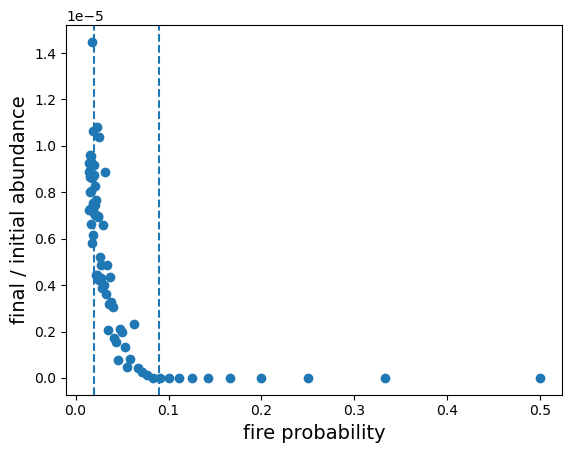

In [62]:
plt.scatter(fire_probs, ab_ratios)
plt.ylabel('final / initial abundance', fontsize=14)
plt.xlabel('fire probability', fontsize=14)
plt.axvline(0.02, ls='--')
plt.axvline(0.09, ls='--')
plt.savefig('figs/popsuc_vs_fireprob.png')

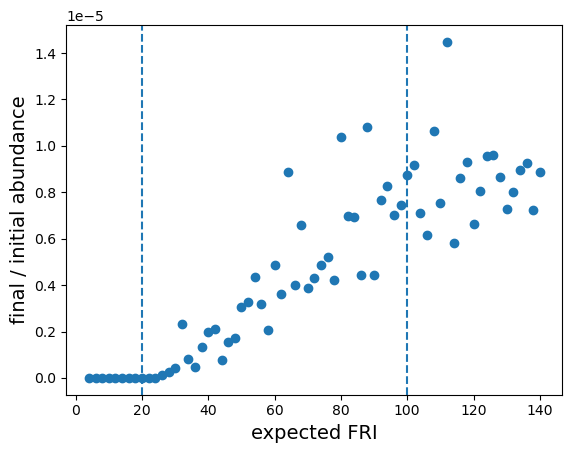

In [63]:
plt.scatter(inst.timestep / np.array(fire_probs), ab_ratios)
plt.ylabel('final / initial abundance', fontsize=14)
plt.xlabel('expected FRI', fontsize=14)
plt.axvline(20, ls='--')
plt.axvline(100, ls='--')
plt.savefig('figs/popsuc_vs_fri.png')

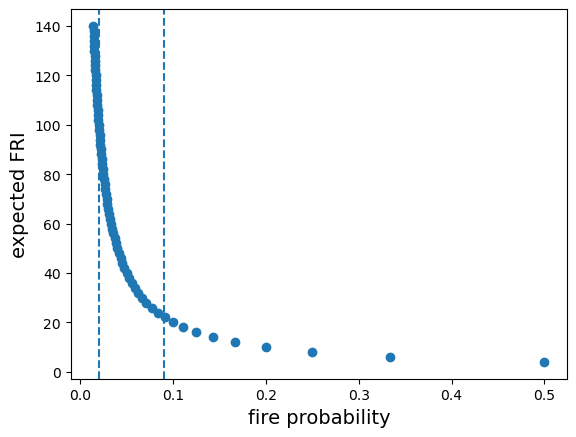

In [64]:
plt.scatter(np.array(fire_probs), inst.timestep / np.array(fire_probs))
plt.axvline(0.02, ls='--')
plt.axvline(0.09, ls='--')
plt.xlabel('fire probability', fontsize=14)
plt.ylabel('expected FRI', fontsize=14)
plt.savefig('figs/fri_vs_fireprob.png')

using existing run: True, run_num=0, run_dir=/Users/patrick/Research/Regan/TecateCypress/runs/0
Inconsistent run_dir in run document


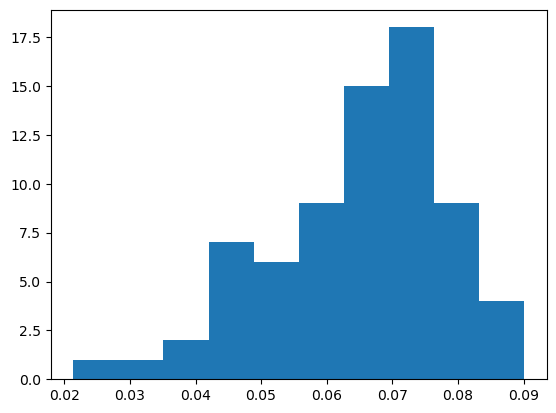

In [65]:
with open(os.path.join(os.getcwd(), 'runs', str(0), 'run_info.json')) as info_file:
    run_info = json.load(info_file)
inst = Model(**run_info)
resdata = get_resdata(inst)
patches = list(resdata['patch_centroids'].keys())
patches.remove('pop0')
avgs = []
for patch in patches:
    probs = resdata['fire_prob'][patch]
    nonzero = probs[np.nonzero(probs)]
    if len(nonzero) > 0:
        avgs.append(np.mean(nonzero))
plt.hist(avgs)
plt.savefig('figs/fireprob_hist.png')